In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import StorageLevel, SparkConf, SparkContext
from pyspark.sql.functions import mean
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
from pyspark.sql.functions import lit

print(_find_spark_home())

/home/lyu0001/anaconda3/envs/BigData/lib/python3.11/site-packages/pyspark


In [27]:
conf = (
    SparkConf()
    .setMaster("local[*]")
    .set("spark.local.dir", "/home/lyu0001/spark-temp")
    .set("spark.driver.memory", "6g")
    .set("spark.executor.memory", "12g")
    .set("spark.driver.maxResultSize", "10g")
    .set("spark.pyspark.python", "/home/lyu0001/anaconda3/bin/python")
    .set("spark.pyspark.driver.python", "/home/lyu0001/anaconda3/bin/python")
)
conf.set("spark.logConf", "true")
spark = (
    SparkSession.builder.appName("PySpark Hadoop Integration")
    .config(conf=conf)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("INFO")  # 可以设置为DEBUG, ERROR, WARN等级别
sc = spark.sparkContext

for item in sc.getConf().getAll():
    print(item)

('spark.sql.warehouse.dir', 'file:/home/lyu0001/Downloads/spark-warehouse')
('spark.app.id', 'local-1704301087306')
('spark.executor.id', 'driver')
('spark.pyspark.python', '/home/lyu0001/anaconda3/bin/python')
('spark.driver.host', '192.168.138.134')
('spark.executor.memory', '12g')
('spark.pyspark.driver.python', '/home/lyu0001/anaconda3/bin/python')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=ja

In [28]:
#展示数据
df = spark.read.option("header", "true").csv("hdfs://localhost:9000/datasets/WeatherForcast")#从HDFS读取数据，并创建一个PySpark DataFrame df

type(df)  #告诉你现在df是pyspark dataframe而不是我们平常用的pandas dataframe，如果你想把现在这个pys-df转为平常用的pan-df，就相当于是下载到本地，太过占用内存，所以不要！
#pyspark dataframe本来就是用来处理数据量比较大的数据的，pan-df只适用于小型数据

df_copy = df.alias("df_copy") #为了防止原始数据被覆盖

#df.show()
df_copy.show()

24/01/03 16:12:26 INFO InMemoryFileIndex: It took 37 ms to list leaf files for 1 paths.
24/01/03 16:12:26 INFO InMemoryFileIndex: It took 27 ms to list leaf files for 3 paths.
24/01/03 16:12:27 INFO FileSourceStrategy: Pushed Filters: 
24/01/03 16:12:27 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#3109, None)) > 0)
24/01/03 16:12:27 INFO CodeGenerator: Code generated in 52.264136 ms
24/01/03 16:12:27 INFO MemoryStore: Block broadcast_85 stored as values in memory (estimated size 351.4 KiB, free 3.0 GiB)
24/01/03 16:12:27 INFO MemoryStore: Block broadcast_85_piece0 stored as bytes in memory (estimated size 34.6 KiB, free 3.0 GiB)
24/01/03 16:12:27 INFO BlockManagerInfo: Added broadcast_85_piece0 in memory on 192.168.138.134:39195 (size: 34.6 KiB, free: 3.0 GiB)
24/01/03 16:12:27 INFO SparkContext: Created broadcast 85 from csv at NativeMethodAccessorImpl.java:0
24/01/03 16:12:27 INFO FileSourceScanExec: Planning scan with bin packing, max size: 134217728 bytes, open co

+----------+------+------+----------+--------------+-------+-----+------+------+-------+-------+----------+
|number_sta|   lat|   lon|height_sta|          date|     dd|   ff|precip|    hu|     td|      t|       psl|
+----------+------+------+----------+--------------+-------+-----+------+------+-------+-------+----------+
|  14066001|49.330|-0.430|     2.000|20160101 00:00|210.000|4.400| 0.000|91.000|278.450|279.850|      NULL|
|  14126001|49.150| 0.040|   125.000|20160101 00:00|   NULL| NULL| 0.000|99.000|278.350|278.450|      NULL|
|  14137001|49.180|-0.460|    67.000|20160101 00:00|220.000|0.600| 0.000|92.000|276.450|277.650|102360.000|
|  14216001|48.930|-0.150|   155.000|20160101 00:00|220.000|1.900| 0.000|95.000|278.250|278.950|      NULL|
|  14296001|48.800|-1.030|   339.000|20160101 00:00|   NULL| NULL| 0.000|  NULL|   NULL|278.350|      NULL|
|  14357002|48.930|-0.690|   223.000|20160101 00:00|   NULL| NULL| 0.000|  NULL|   NULL|277.650|      NULL|
|  14366002|49.170| 0.230|  

24/01/03 16:12:28 INFO CodeGenerator: Code generated in 40.526285 ms
24/01/03 16:12:28 INFO FileScanRDD: Reading File path: hdfs://localhost:9000/datasets/WeatherForcast/NW_Ground_Stations_2016.csv, range: 0-134217728, partition values: [empty row]
24/01/03 16:12:28 INFO Executor: Finished task 0.0 in stage 66.0 (TID 788). 3037 bytes result sent to driver
24/01/03 16:12:28 INFO TaskSetManager: Finished task 0.0 in stage 66.0 (TID 788) in 135 ms on 192.168.138.134 (executor driver) (1/1)
24/01/03 16:12:28 INFO TaskSchedulerImpl: Removed TaskSet 66.0, whose tasks have all completed, from pool 
24/01/03 16:12:28 INFO DAGScheduler: ResultStage 66 (showString at NativeMethodAccessorImpl.java:0) finished in 0.166 s
24/01/03 16:12:28 INFO DAGScheduler: Job 48 is finished. Cancelling potential speculative or zombie tasks for this job
24/01/03 16:12:28 INFO TaskSchedulerImpl: Killing all running tasks in stage 66: Stage finished
24/01/03 16:12:28 INFO DAGScheduler: Job 48 finished: showString a

In [4]:
#打印输出每一列的数据类型，发现是string
column_types = df.dtypes
print(column_types)

[('number_sta', 'string'), ('lat', 'string'), ('lon', 'string'), ('height_sta', 'string'), ('date', 'string'), ('dd', 'string'), ('ff', 'string'), ('precip', 'string'), ('hu', 'string'), ('td', 'string'), ('t', 'string'), ('psl', 'string')]


In [5]:
#将df里所有列从string转为数值类型（浮点类型、整数类型）的数据（因为字符串不能算均值）

all_columns = df.columns

# 循环遍历每列并将其转换为数值类型
for column in all_columns:
    df = df.withColumn(column, df[column].cast(FloatType()))  # 使用 FloatType() 作为示例，你可以根据需要选择其他类型

# 打印结果
df.show() #

+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
| number_sta|   lat|   lon|height_sta|date|   dd|  ff|precip|  hu|    td|     t|     psl|
+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
|1.4066001E7| 49.33| -0.43|       2.0|NULL|210.0| 4.4|   0.0|91.0|278.45|279.85|    NULL|
|1.4126001E7| 49.15|  0.04|     125.0|NULL| NULL|NULL|   0.0|99.0|278.35|278.45|    NULL|
|1.4137001E7| 49.18| -0.46|      67.0|NULL|220.0| 0.6|   0.0|92.0|276.45|277.65|102360.0|
|1.4216001E7| 48.93| -0.15|     155.0|NULL|220.0| 1.9|   0.0|95.0|278.25|278.95|    NULL|
|1.4296001E7|  48.8| -1.03|     339.0|NULL| NULL|NULL|   0.0|NULL|  NULL|278.35|    NULL|
|1.4357002E7| 48.93| -0.69|     223.0|NULL| NULL|NULL|   0.0|NULL|  NULL|277.65|    NULL|
|1.4366002E7| 49.17|  0.23|      62.0|NULL| NULL|NULL|   0.0|NULL|  NULL|279.55|    NULL|
|1.4372001E7|49.102|-0.765|     184.0|NULL|230.0| 4.1|   0.0|92.0|278.05|279.25|    NULL|
|1.4501002

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer

In [7]:
#==============================1.mean value（Imputer）==============#

columns_to_fill = ["dd", "ff", "precip", "hu", "td", "t", "psl"] #需要被填充的列名

# create Imputer output column
imputer = Imputer(inputCols=columns_to_fill, outputCols=[f"{col}" for col in columns_to_fill])

#train Imputer model
imputer_model = imputer.fit(df)

# use imputer to impute 
df_imputed = imputer_model.transform(df)

# print the result
df_imputed.show()

+-----------+------+------+----------+----+---------+---------+-----------+---------+---------+--------+---------+
| number_sta|   lat|   lon|height_sta|date|       dd|       ff|     precip|       hu|       td|       t|      psl|
+-----------+------+------+----------+----+---------+---------+-----------+---------+---------+--------+---------+
|1.4066001E7| 49.33| -0.43|       2.0|NULL|    210.0|      4.4|        0.0|     91.0|   278.45|  279.85|101738.58|
|1.4126001E7| 49.15|  0.04|     125.0|NULL|186.64313|3.8138418|        0.0|     99.0|   278.35|  278.45|101738.58|
|1.4137001E7| 49.18| -0.46|      67.0|NULL|    220.0|      0.6|        0.0|     92.0|   276.45|  277.65| 102360.0|
|1.4216001E7| 48.93| -0.15|     155.0|NULL|    220.0|      1.9|        0.0|     95.0|   278.25|  278.95|101738.58|
|1.4296001E7|  48.8| -1.03|     339.0|NULL|186.64313|3.8138418|        0.0|80.639915|281.39838|  278.35|101738.58|
|1.4357002E7| 48.93| -0.69|     223.0|NULL|186.64313|3.8138418|        0.0|80.63

In [8]:
for column in df.columns:
    df = df.withColumn(column, col(column).cast("string"))
df.show()
#convert the data type back

+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
| number_sta|   lat|   lon|height_sta|date|   dd|  ff|precip|  hu|    td|     t|     psl|
+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
|1.4066001E7| 49.33| -0.43|       2.0|NULL|210.0| 4.4|   0.0|91.0|278.45|279.85|    NULL|
|1.4126001E7| 49.15|  0.04|     125.0|NULL| NULL|NULL|   0.0|99.0|278.35|278.45|    NULL|
|1.4137001E7| 49.18| -0.46|      67.0|NULL|220.0| 0.6|   0.0|92.0|276.45|277.65|102360.0|
|1.4216001E7| 48.93| -0.15|     155.0|NULL|220.0| 1.9|   0.0|95.0|278.25|278.95|    NULL|
|1.4296001E7|  48.8| -1.03|     339.0|NULL| NULL|NULL|   0.0|NULL|  NULL|278.35|    NULL|
|1.4357002E7| 48.93| -0.69|     223.0|NULL| NULL|NULL|   0.0|NULL|  NULL|277.65|    NULL|
|1.4366002E7| 49.17|  0.23|      62.0|NULL| NULL|NULL|   0.0|NULL|  NULL|279.55|    NULL|
|1.4372001E7|49.102|-0.765|     184.0|NULL|230.0| 4.1|   0.0|92.0|278.05|279.25|    NULL|
|1.4501002

In [9]:
selected_column = df_copy.select("number_sta")
df = df.withColumn("number_sta", lit(selected_column.first()["number_sta"]))
df.show()
#将 number_sta 和 date 这两列的所有值替换为 df_copy 中这两列的第一个值。

+----------+------+------+----------+----+-----+----+------+----+------+------+--------+
|number_sta|   lat|   lon|height_sta|date|   dd|  ff|precip|  hu|    td|     t|     psl|
+----------+------+------+----------+----+-----+----+------+----+------+------+--------+
|  14066001| 49.33| -0.43|       2.0|NULL|210.0| 4.4|   0.0|91.0|278.45|279.85|    NULL|
|  14066001| 49.15|  0.04|     125.0|NULL| NULL|NULL|   0.0|99.0|278.35|278.45|    NULL|
|  14066001| 49.18| -0.46|      67.0|NULL|220.0| 0.6|   0.0|92.0|276.45|277.65|102360.0|
|  14066001| 48.93| -0.15|     155.0|NULL|220.0| 1.9|   0.0|95.0|278.25|278.95|    NULL|
|  14066001|  48.8| -1.03|     339.0|NULL| NULL|NULL|   0.0|NULL|  NULL|278.35|    NULL|
|  14066001| 48.93| -0.69|     223.0|NULL| NULL|NULL|   0.0|NULL|  NULL|277.65|    NULL|
|  14066001| 49.17|  0.23|      62.0|NULL| NULL|NULL|   0.0|NULL|  NULL|279.55|    NULL|
|  14066001|49.102|-0.765|     184.0|NULL|230.0| 4.1|   0.0|92.0|278.05|279.25|    NULL|
|  14066001| 48.89| -

In [10]:
selected_column = df_copy.select("date")
df = df.withColumn("date", lit(selected_column.first()["date"]))
df.show()

+----------+------+------+----------+--------------+-----+----+------+----+------+------+--------+
|number_sta|   lat|   lon|height_sta|          date|   dd|  ff|precip|  hu|    td|     t|     psl|
+----------+------+------+----------+--------------+-----+----+------+----+------+------+--------+
|  14066001| 49.33| -0.43|       2.0|20160101 00:00|210.0| 4.4|   0.0|91.0|278.45|279.85|    NULL|
|  14066001| 49.15|  0.04|     125.0|20160101 00:00| NULL|NULL|   0.0|99.0|278.35|278.45|    NULL|
|  14066001| 49.18| -0.46|      67.0|20160101 00:00|220.0| 0.6|   0.0|92.0|276.45|277.65|102360.0|
|  14066001| 48.93| -0.15|     155.0|20160101 00:00|220.0| 1.9|   0.0|95.0|278.25|278.95|    NULL|
|  14066001|  48.8| -1.03|     339.0|20160101 00:00| NULL|NULL|   0.0|NULL|  NULL|278.35|    NULL|
|  14066001| 48.93| -0.69|     223.0|20160101 00:00| NULL|NULL|   0.0|NULL|  NULL|277.65|    NULL|
|  14066001| 49.17|  0.23|      62.0|20160101 00:00| NULL|NULL|   0.0|NULL|  NULL|279.55|    NULL|
|  1406600

In [11]:
sample_df = df.sample(fraction=0.1)  # 抽样，例如抽取10%的数据


In [12]:
from pyspark.sql.functions import isnan, when, count, col

sample_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sample_df.columns]).show()
#check if there is lost in the sample 

+----------+---+---+----------+----+-------+-------+------+-------+-------+------+-------+
|number_sta|lat|lon|height_sta|date|     dd|     ff|precip|     hu|     td|     t|    psl|
+----------+---+---+----------+----+-------+-------+------+-------+-------+------+-------+
|         0|  0|  0|         0|   0|2586633|2584430|378336|2645239|2647200|945072|5259503|
+----------+---+---+----------+----+-------+-------+------+-------+-------+------+-------+



In [13]:
#将df里所有列从string转为数值类型（浮点类型、整数类型）的数据（因为字符串不能算均值）

all_columns = df.columns

# 循环遍历每列并将其转换为数值类型
for column in all_columns:
    df = df.withColumn(column, df[column].cast(FloatType()))  # 使用 FloatType() 作为示例，你可以根据需要选择其他类型

# 打印结果
df.show() #

+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
| number_sta|   lat|   lon|height_sta|date|   dd|  ff|precip|  hu|    td|     t|     psl|
+-----------+------+------+----------+----+-----+----+------+----+------+------+--------+
|1.4066001E7| 49.33| -0.43|       2.0|NULL|210.0| 4.4|   0.0|91.0|278.45|279.85|    NULL|
|1.4066001E7| 49.15|  0.04|     125.0|NULL| NULL|NULL|   0.0|99.0|278.35|278.45|    NULL|
|1.4066001E7| 49.18| -0.46|      67.0|NULL|220.0| 0.6|   0.0|92.0|276.45|277.65|102360.0|
|1.4066001E7| 48.93| -0.15|     155.0|NULL|220.0| 1.9|   0.0|95.0|278.25|278.95|    NULL|
|1.4066001E7|  48.8| -1.03|     339.0|NULL| NULL|NULL|   0.0|NULL|  NULL|278.35|    NULL|
|1.4066001E7| 48.93| -0.69|     223.0|NULL| NULL|NULL|   0.0|NULL|  NULL|277.65|    NULL|
|1.4066001E7| 49.17|  0.23|      62.0|NULL| NULL|NULL|   0.0|NULL|  NULL|279.55|    NULL|
|1.4066001E7|49.102|-0.765|     184.0|NULL|230.0| 4.1|   0.0|92.0|278.05|279.25|    NULL|
|1.4066001

In [14]:
from pyspark.sql.functions import mean, col

# Now we use this method to impute the whole df again
mean_values = df.select([mean(c).alias(c) for c in ['ff', 'precip', 'hu', 'td', 't', 'psl']]).collect()[0].asDict()
for column in mean_values:
    df =df.na.fill(mean_values[column], [column])
    #mean value to impute the data column
    dd_mean = df.select(mean(col("dd"))).collect()[0][0]
df = df.na.fill({"dd": dd_mean})

In [15]:
selected_column = df_copy.select("number_sta")
df = df.withColumn("number_sta", lit(selected_column.first()["number_sta"]))
selected_column = df_copy.select("date")
df = df.withColumn("date", lit(selected_column.first()["date"]))

#将 number_sta 和 date 这两列的所有值替换为 df_copy 中这两列的第一个值。

In [16]:
df.show()
df.printSchema()
#check the df and the data type is float

+----------+------+------+----------+--------------+---------+---------+-----------+---------+---------+--------+---------+
|number_sta|   lat|   lon|height_sta|          date|       dd|       ff|     precip|       hu|       td|       t|      psl|
+----------+------+------+----------+--------------+---------+---------+-----------+---------+---------+--------+---------+
|  14066001| 49.33| -0.43|       2.0|20160101 00:00|    210.0|      4.4|        0.0|     91.0|   278.45|  279.85|101738.58|
|  14066001| 49.15|  0.04|     125.0|20160101 00:00|186.64313|3.8138418|        0.0|     99.0|   278.35|  278.45|101738.58|
|  14066001| 49.18| -0.46|      67.0|20160101 00:00|    220.0|      0.6|        0.0|     92.0|   276.45|  277.65| 102360.0|
|  14066001| 48.93| -0.15|     155.0|20160101 00:00|    220.0|      1.9|        0.0|     95.0|   278.25|  278.95|101738.58|
|  14066001|  48.8| -1.03|     339.0|20160101 00:00|186.64313|3.8138418|        0.0|80.639915|281.39838|  278.35|101738.58|
|  14066

In [17]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sample_df.columns]).show()
#we can see now through all of the steps there are no empety values in our df

+----------+---+---+----------+----+---+---+------+---+---+---+---+
|number_sta|lat|lon|height_sta|date| dd| ff|precip| hu| td|  t|psl|
+----------+---+---+----------+----+---+---+------+---+---+---+---+
|         0|  0|  0|         0|   0|  0|  0|     0|  0|  0|  0|  0|
+----------+---+---+----------+----+---+---+------+---+---+---+---+



# data analysis

In [18]:
df.describe(['lat', 'lon', 'height_sta', 'dd', 'ff', 'precip', 'hu', 'td', 't', 'psl']).show()

24/01/03 09:16:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+------------------+
|summary|              lat|                lon|        height_sta|                dd|                ff|              precip|                hu|               td|                t|               psl|
+-------+-----------------+-------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+------------------+
|  count|         65826837|           65826837|          65826837|          65826837|          65826837|            65826837|          65826837|         65826837|         65826837|          65826837|
|   mean|48.05658456797023|-0.5580410393577268|107.13719767516704|186.64313077881005|3.8138418668928225|0.008400893755019038| 80.63991598569562|281.3983730705495|285.0512112584801|101738.57864039176|


In [19]:
grouped_df = df.groupBy("lat", "lon").agg(
    mean("t").alias("avg_temperature"),
    mean("hu").alias("avg_humidity"),
    mean("psl").alias("avg_pressure"),
    mean("ff").alias("avg_wind_speed")
)
grouped_df.show()
#Perform statistical analysis for each geographical location

+------+-----+------------------+-----------------+------------------+------------------+
|   lat|  lon|   avg_temperature|     avg_humidity|      avg_pressure|    avg_wind_speed|
+------+-----+------------------+-----------------+------------------+------------------+
| 47.23| 0.15| 285.1323904573657| 77.9698556251172|     101738.578125| 3.001862708161458|
| 49.03| 1.22| 283.7046346046953|80.10250991514853|101727.51736882451| 3.730466305755502|
| 48.26| 0.91|282.15465934922946| 82.7644404943713|     101738.578125|3.0678722505688643|
| 47.62| 0.46| 285.5878378213047|76.69804581690286|     101738.578125|3.0082698566903865|
| 48.93|-0.69|283.33769510348156| 80.6399154663086|     101738.578125|3.8138418197631836|
| 46.94| 1.66| 284.8764653821383|80.43129009817832|     101738.578125|3.8138418197631836|
| 48.05|-3.66| 279.4722244112887| 89.8107263224735|     101738.578125| 3.836272162274425|
| 47.64|-2.62|284.92851157953396| 80.6399154663086|     101738.578125|3.8138418197631836|
| 48.55|-3

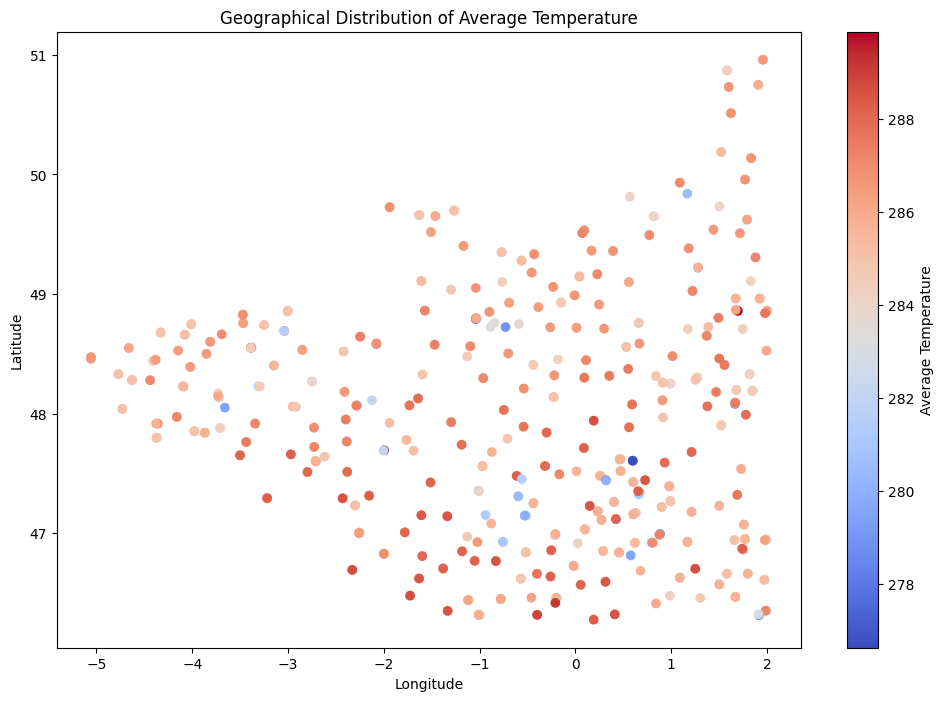

In [20]:
# 转换为 Pandas DataFrame
grouped_df_pd = grouped_df.toPandas()

# 可视化代码
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# 创建散点图，例如，展示平均温度
plt.scatter(grouped_df_pd['lon'], grouped_df_pd['lat'], c=grouped_df_pd['avg_temperature'], cmap='coolwarm')
plt.colorbar(label='Average Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Average Temperature')
plt.show()

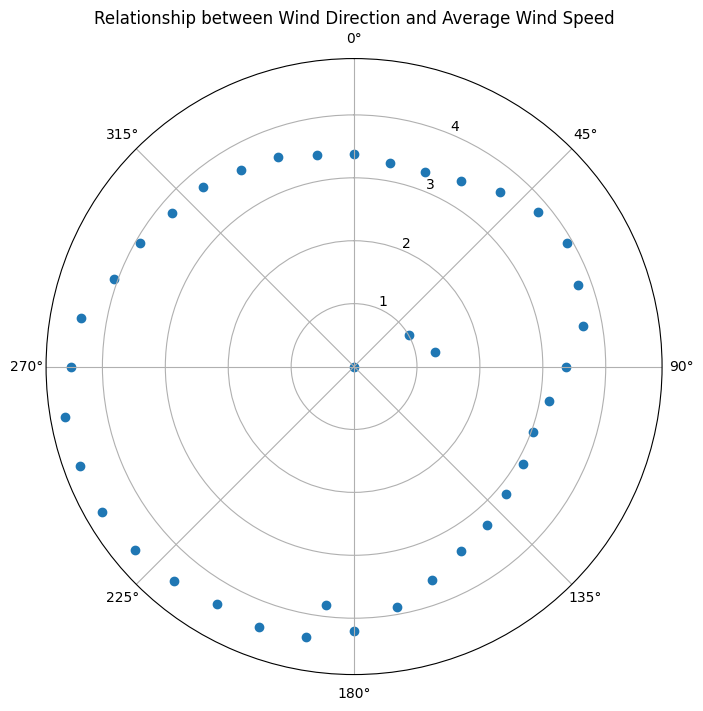

In [21]:
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
import numpy as np

# 1. 聚合数据
wind_agg_df = df.groupBy("dd").agg(mean("ff").alias("avg_wind_speed"))

# 2. 转换为 Pandas DataFrame
wind_agg_df_pd = wind_agg_df.toPandas()

# 3. 可视化
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# 将风向转换为弧度，以便在极坐标图中使用
radians = np.deg2rad(wind_agg_df_pd['dd'])

# 绘制极坐标图
ax.scatter(radians, wind_agg_df_pd['avg_wind_speed'])

ax.set_theta_zero_location('N')  # 设置北方为0度
ax.set_theta_direction(-1)  # 设置角度方向为顺时针

plt.title('Relationship between Wind Direction and Average Wind Speed')
plt.show()


In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# 假设我们想分析温度（t）如何受到其他参数的影响
assembler = VectorAssembler(inputCols=[col for col in columns_to_fill if col != 't'], outputCol="features")
df_vec = assembler.transform(df)

# 线性回归模型
lr = LinearRegression(featuresCol='features', labelCol='t')
lr_model = lr.fit(df_vec)

# 输出模型的系数和截距
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# 模型评估
trainingSummary = lr_model.summary
print(f"RMSE: {trainingSummary.rootMeanSquaredError}")
print(f"r2: {trainingSummary.r2}")


24/01/03 09:29:11 WARN Instrumentation: [08270ab5] regParam is zero, which might cause numerical instability and overfitting.
24/01/03 09:29:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/03 09:33:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [0.0007270740378097658,-0.046856075221074434,-0.007112746474605054,-0.23452775100580553,0.9706427687128484,-3.607202365145096e-05]
Intercept: 34.53918790249344
RMSE: 3.636454417933513
r2: 0.6592910614742807


In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# 构建和训练模型
assembler = VectorAssembler(inputCols=[col for col in columns_to_fill if col != 't'], outputCol="features")
df_vec = assembler.transform(df)
lr = LinearRegression(featuresCol='features', labelCol='t')
lr_model = lr.fit(df_vec)

# 在这里获取模型的系数和截距
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# 添加用于获取和比较特定系数的代码
coefficients = lr_model.coefficients
precip_index = columns_to_fill.index('precip') - 1  # 根据特征顺序调整
dd_index = columns_to_fill.index('dd') - 1

precip_coeff = coefficients[precip_index]
dd_coeff = coefficients[dd_index]

print(f"Coefficient for precipitation (precip): {precip_coeff}")
print(f"Coefficient for wind direction (dd): {dd_coeff}")

if abs(precip_coeff) > abs(dd_coeff):
    print("Precipitation has a greater impact on temperature.")
else:
    print("Wind direction has a greater impact on temperature.")


24/01/03 10:10:13 WARN Instrumentation: [f950338f] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [0.0007270740378097658,-0.046856075221074434,-0.007112746474605054,-0.23452775100580553,0.9706427687128484,-3.607202365145096e-05]
Intercept: 34.53918790249344
Coefficient for precipitation (precip): -0.046856075221074434
Coefficient for wind direction (dd): -3.607202365145096e-05
Precipitation has a greater impact on temperature.
